# Тестовое задание на позицию DS'а

## Описание датасета

В этом задании предлагается классифицировать сообщения на предмет того, из какого чата они были взяты. Датасет представляет собой сообщения участников двух публичных чатов:
* Чат по Python (label=0)
* Чат по Data Science (label=1)

## Описание задачи

Ваша задача:
1. Сделать предобработку текстов
2. Предложить модель классификации, метрики.
3. Объяснить их выбор (достоинства/недостатки). 
4. Сделать выводы по работе модели(ей) (достоинства/недостатки), а также проблемы, с которыми вы или ваша модель столкнулась.

Было бы интересно посмотреть не только на финальное решение, но и на эксперименты (даже провальные). 

## Загрузка данных

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)

df = pd.read_csv('data/train.csv')
df.sample(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,text,label
2124,"И даже предполагая, какой может быть лучше,лучше все таки попробовать оба.",1
5656,"это все ясно, я ищу - как сделать трансформацию не убив особенности",1
6002,много слов? выгоднее идти по тексту и искать его слова в списке,0
5564,"но ведь у тебя же есть высшее образование, т.е. и вышку ты проходила, т.е. тебе надо освежить знания, а не учить с нуля",1
11416,"вдогонку, в питоне можно сделать классический синглтон через __new__ и __init__, но как правило это нафиг не нужно",0


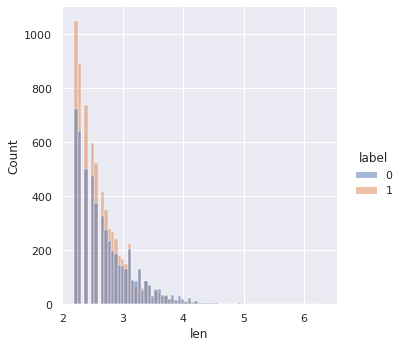

In [100]:
import seaborn

seaborn.set(rc={'figure.figsize':(15,15)})

df['len'] = df['text'].apply(lambda x: np.log(len(x.split(' '))))

seaborn.displot(df, x='len', hue="label")
# распределения кол-ва слов в сбщ одинаковые для двух чатов, смысла в этой фиче нет

## Ваше решение

## Будет предоставлено 2 "высокоуровневых" решения:
- bag of words + classical ML (Naive Bayes, Boosting, SVM, LinReg)
- bow и/или embedding (предобученный на русских+англ словах) + NN (CNN)

Чтобы быть совсем честными, для определения наилучшей модели, мы сразу разобьем данные на train и test, BOW будем делать отдельные и все такое.
А потом, определившись с лучшей моделью, еще раз ее переобучим на всех данных и в docker упакуем именно ее.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

In [72]:
texts = df['text'].values
target = df['label'].values

texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.2, random_state=42)

In [73]:
print(sum(target==1))
print(sum(target==0))
# данные почти сбалансированы, это хорошо

6885
5519


In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [75]:
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords

tokenizer = WordPunctTokenizer()

preprocess = lambda text: ' '.join([word for word in tokenizer.tokenize(text.lower()) 
                                    if word not in stopwords.words('russian')
                                    and word not in stopwords.words('english')])


texts_train = np.array(list(map(preprocess, texts_train)))
texts_test = np.array(list(map(preprocess, texts_test)))

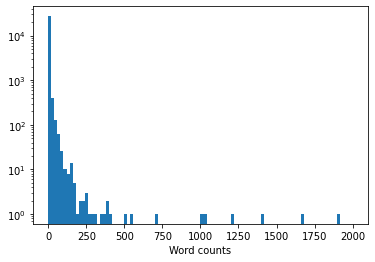

In [76]:
from collections import Counter


token_counts = Counter()

for message in texts_train:
    token_counts.update(message.split())

    
plt.hist(list(token_counts.values()), range=[0, 2*10**3], bins=100, log=True)
plt.xlabel("Word counts");

Будут использованы токены из 1 слова и биграммы. 

In [256]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from xgboost import XGBClassifier


pipeline_1 = Pipeline([
    ('vect', CountVectorizer(max_df=1000, min_df=2)),
    ('clf', MultinomialNB()),
])
#pipeline_1.fit(texts_train, y_train)


pipeline_2 = Pipeline([
    ('vect', CountVectorizer(max_df=1000, min_df=2)),
    ('clf', LogisticRegression()),
])
#pipeline_2.fit(texts_train, y_train)


pipeline_3 = Pipeline([
    ('vect', CountVectorizer(max_df=1000, min_df=2)),
    ('clf', SGDClassifier()),
])
#pipeline_3.fit(texts_train, y_train)


pipeline_4 = Pipeline([
    ('vect', CountVectorizer(max_df=1000, min_df=2)),
    ('clf', XGBClassifier()),
])
#pipeline_4.fit(texts_train, y_train)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, accuracy_score


pipeline_1.fit(texts_train, y_train)
pipeline_2.fit(texts_train, y_train)
pipeline_3.fit(texts_train, y_train)
pipeline_4.fit(texts_train, y_train)


#print('Naive Bayes', classification_report(y_test, pipeline_1.predict(texts_test)))
print('Naive Bayes roc-auc', roc_auc_score(y_test, pipeline_1.predict_proba(texts_test)[:,1]))
print('Naive Bayes accuracy', accuracy_score(y_test, pipeline_1.predict(texts_test)))
#print('LogReg', classification_report(y_test, pipeline_2.predict(texts_test)))
print('LogReg roc-auc', roc_auc_score(y_test, pipeline_2.predict_proba(texts_test)[:,1]))
print('LogReg accuracy', accuracy_score(y_test, pipeline_2.predict(texts_test)))
#print('SVM', classification_report(y_test, pipeline_3.predict(texts_test)))
#print('SVM roc-auc', roc_auc_score(y_test, pipeline_3.predict_proba(texts_test)[:,1]))
print('SVM accuracy', accuracy_score(y_test, pipeline_3.predict(texts_test)))
#print('Boosting', classification_report(y_test, pipeline_4.predict(texts_test)))
print('Boosting roc-auc', roc_auc_score(y_test, pipeline_4.predict_proba(texts_test)[:,1]))
print('Boosting accuracy', accuracy_score(y_test, pipeline_4.predict(texts_test)))

Naive Bayes roc-auc 0.853585294431851
Naive Bayes accuracy 0.7780763030628695
LogReg roc-auc 0.8267699642780313
LogReg accuracy 0.754433100483611
SVM accuracy 0.7286405158516926
Boosting roc-auc 0.7541687581311015
Boosting accuracy 0.6947877485222999


In [160]:
# я пробовала тут TfidfVectorizer для классических алгоритмов, особого выигрыша они не дали 

pipeline_5 = Pipeline([
    ('vect', TfidfVectorizer(max_df=500, min_df=2)),
    ('clf', LogisticRegression()),
])

pipeline_5.fit(texts_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=500, max_features=None,
                                 min_df=2, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=

In [161]:
print('logreg tfidf roc-auc', roc_auc_score(y_test, pipeline_5.predict_proba(texts_test)[:,1]))
print('logreg tfidf accuracy', accuracy_score(y_test, pipeline_5.predict(texts_test)))

logreg tfidf roc-auc 0.8306202100586392
logreg tfidf accuracy 0.7517463729177861


In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
%%time

params1 = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'clf__alpha': np.arange(0.1, 1.1, 0.2),
}

optimizer1 = GridSearchCV(estimator=pipeline_1, param_grid=params1, cv=5, n_jobs=-1, scoring = 'accuracy')
optimizer1.fit(texts_train, y_train)
print('Naive Bayes, best score', optimizer1.best_score_)
print('Naive Bayes, best params', optimizer1.best_params_)
print('Naive Bayes, roc-auc', roc_auc_score(y_test, optimizer1.predict_proba(texts_test)[:, 1]))

# качество почти не изменилось, наивный баес отпадает

Naive Bayes, best score 0.7646855243295156
Naive Bayes, best params {'clf__alpha': 0.7000000000000001, 'vect__ngram_range': (1, 1)}
Naive Bayes, roc-auc 0.8544463680226185
CPU times: user 510 ms, sys: 195 ms, total: 705 ms
Wall time: 11.4 s


In [ ]:
%%time

params2 = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'clf__C': np.arange(0.1, 5, 1.),
    'clf__penalty': ["l1","l2"]
}

optimizer2 = GridSearchCV(estimator=pipeline_2, param_grid=params2, cv=10, n_jobs=-1, scoring = 'accuracy')
optimizer2.fit(texts_train, y_train)
print('LogReg, best score', optimizer2.best_score_)
print('LogReg, best params', optimizer2.best_params_)
print('LogReg, roc-auc', roc_auc_score(y_test, optimizer2.predict_proba(texts_test)[:, 1]))

LogReg, best score 0.7499429928993017
LogReg, best params {'clf__C': 1.1, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1)}
LogReg, roc-auc 0.8264570860766274
CPU times: user 1.25 s, sys: 196 ms, total: 1.45 s
Wall time: 53.2 s


In [ ]:
%%time

params3 = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'clf__penalty': ["l1","l2"],
    'clf__alpha': [0.0001,0.001, 0.01, 0.1, 1, 10],
    'clf__average': [True, False]
}

optimizer3 = GridSearchCV(estimator=pipeline_3, param_grid=params3, cv=10, n_jobs=-1, scoring = 'accuracy')
optimizer3.fit(texts_train, y_train)
print('SVM, best score', optimizer3.best_score_)
print('SVM, best params', optimizer3.best_params_)

SVM, best score 0.7373856543619712
SVM, best params {'clf__alpha': 0.0001, 'clf__average': True, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1)}
CPU times: user 2.15 s, sys: 247 ms, total: 2.4 s
Wall time: 2min 25s


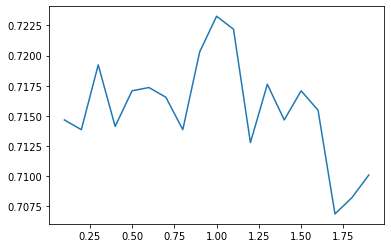

CPU times: user 2min 40s, sys: 3.81 s, total: 2min 44s
Wall time: 1min 30s


In [ ]:
%%time

#max_depth = 13
#ngram=(1, 1)
#min_df=5
#max_df=2000
#learning_rate=0.4
#n_estimators=125
#gamma=1.15
#min_child_weight=1

scores = []
for cw in np.arange(0.1, 2, 0.1):
    model = Pipeline([
        ('vect', CountVectorizer(max_df=1000, min_df=2, ngram_range=(1, 1))),
        ('clf', XGBClassifier(max_depth=13, learning_rate=0.4, n_estimators=125, gamma=1.15, min_child_weight=1)),
    ])
    model.fit(texts_train, y_train)
    scores.append(accuracy_score(y_test, model.predict(texts_test)))
    
plt.plot(np.arange(0.1, 2, 0.1), scores)
plt.show()

In [ ]:
boost = Pipeline([
        ('vect', CountVectorizer(max_df=1000, min_df=2, ngram_range=(1, 1))),
        ('clf', XGBClassifier(max_depth=13, learning_rate=0.4, n_estimators=125, gamma=1.15, min_child_weight=1)),
    ])
boost.fit(texts_train, y_train)
print('Boosting roc-auc', roc_auc_score(y_test, boost.predict_proba(texts_test)[:,1]))
print('Boosting accuracy', accuracy_score(y_test, boost.predict(texts_test)))

Boosting roc-auc 0.792577557354906
Boosting accuracy 0.7181622783449758


### Как бы мы не старались, BOW + classic ML (и дает в лучшем случае 0.85 roc-auc и примерно 0.76 accuracy. Будет считать эту модель бейзлайном

### Дальше будет bow в NN (преимущественно я обучала разные версии CNN), но они не дали профита, лучший вариант все та же давал 0.76-0.78 accuracy.

In [258]:
from sklearn.manifold import TSNE


X_train = CountVectorizer(max_df=250, min_df=2).fit_transform(texts_train)
tsne = TSNE(random_state=42).fit_transform(X_train, y_train)

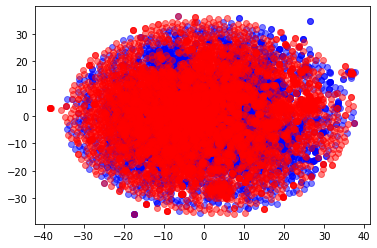

In [259]:
plt.scatter(tsne[y_train==0, 0], 
            tsne[y_train==0, 1], c='blue', alpha=0.5)

plt.scatter(tsne[y_train==1, 0], 
            tsne[y_train==1, 1], c='red', alpha=0.5)

plt.show()

In [263]:
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import pairwise_distances

data_cos = pairwise_distances(X_train[:1000], metric='cosine')

mds = MDS(random_state=42).fit_transform(X_train[:1000].toarray(), y_train[:1000])
mds_cos = MDS(random_state=42, dissimilarity='precomputed').fit_transform(data_cos, y_train[:1000])

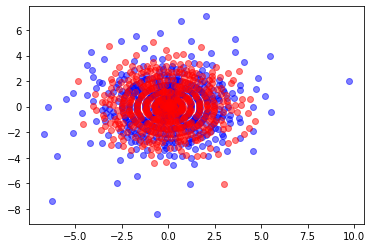

In [264]:
plt.scatter(mds[y_train[:1000]==0, 0], 
            mds[y_train[:1000]==0, 1], c='blue', alpha=0.5)
plt.scatter(mds[y_train[:1000]==1, 0], 
            mds[y_train[:1000]==1, 1], c='red', alpha=0.5)

plt.show()

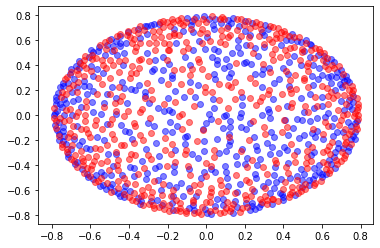

In [261]:
plt.scatter(mds_cos[y_train[:1000]==0, 0], 
            mds_cos[y_train[:1000]==0, 1], c='blue', alpha=0.5)
plt.scatter(mds_cos[y_train[:1000]==1, 0], 
            mds_cos[y_train[:1000]==1, 1], c='red', alpha=0.5)

plt.show()

In [ ]:
import gensim.downloader
from gensim.models.word2vec import Word2Vec

# в предобученных w2v-ах нет приличной части слов, для некоторых сообщений - вообще нет ни одного
#видимо, идея сорвалась
embeddings = gensim.downloader.load("glove-wiki-gigaword-100")

# я пыталась обучаться на векторах эмбедингов, но качество получалось ниже, чем с BOW
# поэтому удалила это все и перешла к NN.

In [ ]:
def vectorize_sum(message):

    embedding_dim = embeddings.vectors.shape[1]
    features = np.zeros([embedding_dim], dtype='float32')
    
    for token in message.split(' '):
        try:
            features += embeddings.get_vector(token)
        except:
            continue
    
    return features

In [ ]:
X_train_wv = np.stack([vectorize_sum(text) for text in texts_train])
X_test_wv = np.stack([vectorize_sum(text) for text in texts_test])

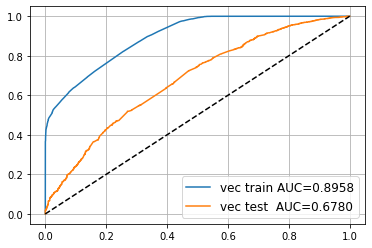

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

wv_model = XGBClassifier().fit(X_train_wv, y_train)

for name, X, y, model in [
    ('vec train', X_train_wv, y_train, wv_model),
    ('vec test ', X_test_wv, y_test, wv_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

### NN

In [4]:
df['text'] = df.text.apply(lambda x: x.replace('\\n', ' '))


texts = df['text'].values
target = df['label'].values

texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.2, random_state=42)

In [109]:
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import string
import re


remove = string.punctuation
pattern = r"[{}]".format(remove)
stem_ru = SnowballStemmer('russian')
stem_en = SnowballStemmer('english')

stem = lambda x: stem_ru.stem(stem_en.stem(x))
tokenizer = WordPunctTokenizer()

preprocess = lambda text: ' '.join([stem(word) for word in 
                                    tokenizer.tokenize(re.sub(pattern, "", text.lower()))
                                    if word not in stopwords.words('russian')
                                    and word not in stopwords.words('english')
                                    and not word.isdigit()])


texts_train = np.array(list(map(preprocess, texts_train)))
texts_test = np.array(list(map(preprocess, texts_test)))

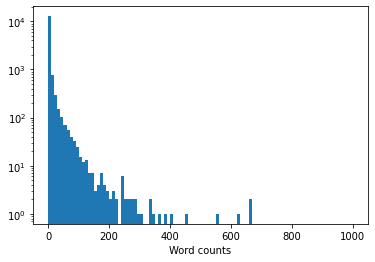

In [110]:
from collections import Counter


token_counts = Counter()

for message in texts_train:
    token_counts.update(message.split())

    
plt.hist(list(token_counts.values()), range=[0, 10**3], bins=100, log=True)
plt.xlabel("Word counts");

In [118]:
tokens =  [t for t, cnt in token_counts.items() if cnt >= 2 and cnt <= 250 and len(t) > 1]

UNK, PAD = "UNK", "PAD" 
tokens = [UNK, PAD] + sorted(tokens)
tokens = tokens[:-6] # убираем всякие смайлы и тп

token_to_id = {t: i for i, t in enumerate(tokens)}
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

In [252]:
import json

with open('tokens2.json', 'w', encoding='utf-8') as f:
    json.dump(token_to_id, f, indent=4, ensure_ascii=False)

In [120]:
# convert to keras input

def as_matrix(sequences, max_len=None):
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [121]:
def make_batch(text, max_len=None, word_dropout=0):
    batch = {}
    batch["text"] = as_matrix(text, max_len)    
    if word_dropout != 0:
        batch["text"] = apply_word_dropout(batch["text"], 1. - word_dropout)
    
    return batch

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [122]:
import keras
import keras.layers as L
import tensorflow as tf

In [123]:
def iterate_minibatches(data, labels, batch_size=256, shuffle=True, cycle=False, **kwargs):
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(np.take(data, indices[start : start + batch_size]),
                               **kwargs)
            target = np.take(labels, indices[start : start + batch_size])
            yield batch, target
        
        if not cycle: break

In [183]:
model = keras.Sequential([
      L.Embedding(len(tokens), 8, input_shape=[None]),
      L.Dropout(0.6),
      #L.Conv1D(filters=8, kernel_size=2, activation='relu'),
      #L.Dropout(0.5),
      L.GlobalAveragePooling1D(),
      #L.Dropout(0.5),
      L.Dense(16, activation='relu'),
      L.Dropout(0.6),
      L.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_46 (Embedding)     (None, None, 8)           53688     
_________________________________________________________________
dropout_110 (Dropout)        (None, None, 8)           0         
_________________________________________________________________
global_average_pooling1d_44  (None, 8)                 0         
_________________________________________________________________
dense_77 (Dense)             (None, 16)                144       
_________________________________________________________________
dropout_111 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_78 (Dense)             (None, 1)                 17        
Total params: 53,849
Trainable params: 53,849
Non-trainable params: 0
_________________________________________________

In [184]:
batch_size = 64
epochs = 30            # definitely too small
steps_per_epoch = 100 # (len(texts_train) - 1) // batch_size + 1  # for full pass over data: (len(data_train) - 1) // batch_size + 1


model.compile('adam', 'binary_crossentropy', metrics=['binary_accuracy', tf.keras.metrics.AUC()])

model.fit(iterate_minibatches(texts_train, y_train, batch_size, cycle=True, word_dropout=0.1), 
                    epochs=epochs, steps_per_epoch=steps_per_epoch,
                    
                    validation_data=iterate_minibatches(texts_test, y_test, batch_size, cycle=True),
                    validation_steps=texts_test.shape[0] // batch_size
                   )

Epoch 1/30
100/100 [==============================] - 2s 8ms/step - loss: 0.6898 - binary_accuracy: 0.5514 - auc_48: 0.5075 - val_loss: 0.6825 - val_binary_accuracy: 0.5732 - val_auc_48: 0.5868
Epoch 2/30
100/100 [==============================] - 1s 5ms/step - loss: 0.6848 - binary_accuracy: 0.5566 - auc_48: 0.5391 - val_loss: 0.6777 - val_binary_accuracy: 0.5752 - val_auc_48: 0.6456
Epoch 3/30
100/100 [==============================] - 1s 5ms/step - loss: 0.6838 - binary_accuracy: 0.5522 - auc_48: 0.5797 - val_loss: 0.6731 - val_binary_accuracy: 0.5855 - val_auc_48: 0.6650
Epoch 4/30
100/100 [==============================] - 1s 6ms/step - loss: 0.6767 - binary_accuracy: 0.5813 - auc_48: 0.5883 - val_loss: 0.6645 - val_binary_accuracy: 0.6188 - val_auc_48: 0.7256
Epoch 5/30
100/100 [==============================] - 1s 6ms/step - loss: 0.6677 - binary_accuracy: 0.6054 - auc_48: 0.6481 - val_loss: 0.6507 - val_binary_accuracy: 0.6435 - val_auc_48: 0.7763
Epoch 6/30
100/100 [==========

In [216]:
for el in model.predict(make_batch(texts_test[250:255])):
  print(el)

[0.99268836]
[1.]
[0.99999416]
[0.00010814]
[0.86820275]


In [217]:
list(zip(texts_test[250:255], y_test[250:255]))

[('согласн смущ высказ никак факт', 1),
 ('эт хорош вопрос цел конкурс провод агрегир категор', 1),
 ('теоретическ adversar долж помог чет помог особ семпл трейн похож тест', 1),
 ('питон функц счит возвращ хот реальн int', 0),
 ('взгляд эт интересн задач остальн техническ сложн', 1)]

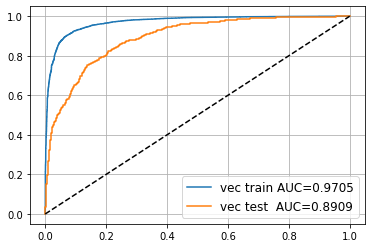

In [192]:
from sklearn.metrics import roc_auc_score, roc_curve


for name, X, y, model in [
    ('vec train', make_batch(texts_train), y_train, model),
    ('vec test ', make_batch(texts_test), y_test, model)
]:
    proba = model.predict(X)
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

In [201]:
from sklearn.metrics import classification_report

print(classification_report(y_test, (model.predict(make_batch(texts_test))>0.5).astype("int32")))

              precision    recall  f1-score   support

           0       0.90      0.56      0.69      1056
           1       0.75      0.96      0.84      1425

    accuracy                           0.79      2481
   macro avg       0.82      0.76      0.76      2481
weighted avg       0.81      0.79      0.78      2481



In [234]:
model.evaluate(iterate_minibatches(texts_test, y_test, cycle=False, batch_size=texts_test.shape[0] // 64))

66/66 [==============================] - 0s 2ms/step - loss: 0.4249 - binary_accuracy: 0.8154 - auc_48: 0.8887


[0.42488449811935425, 0.8153970241546631, 0.8887104392051697]

In [241]:
model.save('tf_model.h5', save_format='h5')

In [244]:
for el in another_model.predict(make_batch(texts_test[250:255])):
  print(el)

[0.99268836]
[1.]
[0.99999416]
[0.00010814]
[0.86820275]


Итоговую модель далее нужно:
1. Обернуть в класс
2. Развернуть модель как REST API
3. Предоставить инструкцию что нужно сделать чтобы развернуть апи модели у себя на компьютере 

In [166]:
# я честно хотела взять предобученные elmo и/или bert эмбеды от deeppavlov, но каждый из файлов весит больше 1Гб
# оборачивать это в докер мне показалось нерентабельным

In [254]:
!pip show numpy pandas tensorflow keras nltk | grep -A1 Name

Name: numpy
Version: 1.19.4
--
Name: pandas
Version: 1.1.5
--
Name: tensorflow
Version: 2.4.0
--
Name: Keras
Version: 2.4.3
--
Name: nltk
Version: 3.2.5
